In [3]:
import numpy as np
import torch
import networkx as nx

from src.causal_recourse_gen import CausalRecourseGenerator, eval_actions_numpy

In [4]:
%load_ext autoreload
%autoreload 2

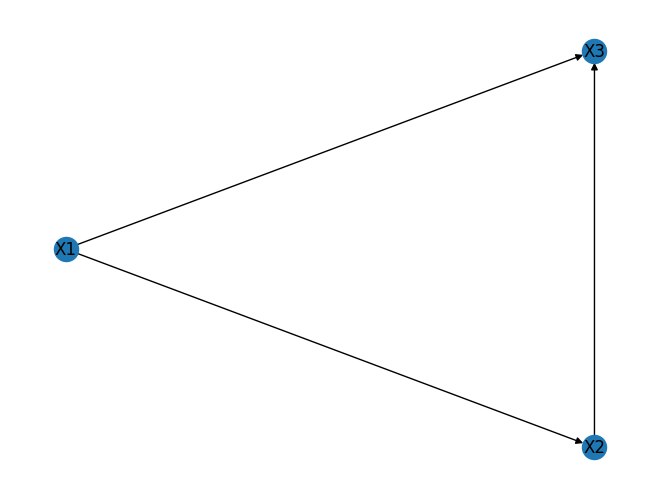

In [5]:
W_adjacency = np.array([[0, 0.3, 0.2], [0, 0, -0.4], [0, 0, 0]])
# draw graph from adjacency matrix
G = nx.from_numpy_array(W_adjacency, create_using=nx.DiGraph)
nx.draw_shell(G, with_labels=True, labels={0: "X1", 1: "X2", 2: "X3"})

In [6]:
W_classifier = np.array([0.5, 0.6, 0.7])
b_classifier = -0.5

In [7]:
X = np.array([[0.2, -0.8, -0.4], [-0.6, -0.9, -0.3]])

In [8]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [9]:
sigmoid(X @ W_classifier + b_classifier)

array([0.23866729, 0.17508627])

In [10]:
recourse_gen = CausalRecourseGenerator(learn_beta=False, learn_ordering=False)
recourse_gen.add_data(
    X=torch.tensor(X),
    W_adjacency=torch.tensor(W_adjacency),
    W_classifier=torch.tensor(W_classifier),
    b_classifier=torch.tensor(b_classifier),
)
recourse_gen.set_ordering(torch.Tensor([0, 1, 2]).repeat(2, 1))
recourse_gen.set_beta(torch.Tensor([1, 1, 1]))
recourse_df = recourse_gen.gen_recourse(classifier_margin=0, max_epochs=2000)

In [11]:
recourse_df

,X1,X2,X3,a1,a2,a3,order1,order2,order3,cost,prob
0,0.953329,-0.280019,0.276159,0.753343,0.293988,0.643098,0.0,1.0,2.0,1.067489,0.500491
1,0.408190,-0.204103,0.604912,1.008176,0.393434,0.860638,0.0,1.0,2.0,1.911959,0.501268


In [12]:
# sample different betas
betas = np.random.uniform(0, 2, (50, 3))

In [13]:
actions = np.empty((50, 2, 3))
costs = np.empty((50, 2))

for i, beta in enumerate(betas):
    recourse_gen.set_beta(torch.tensor(beta, dtype=torch.float32))
    df = recourse_gen.gen_recourse(classifier_margin=0.02, max_epochs=2000)
    actions[i] = df[["a1", "a2", "a3"]].values
    costs[i] = df["cost"].values

In [ ]:
recourse_gen = CausalRecourseGenerator(learn_beta=False, learn_ordering=False)
recourse_gen.add_data(
    X=torch.tensor(X),
    W_adjacency=torch.tensor(W_adjacency),
    W_classifier=torch.tensor(W_classifier),
    b_classifier=torch.tensor(b_classifier),
)
recourse_gen.set_ordering(torch.Tensor([0, 1, 2]).repeat(2, 1))
recourse_gen.set_beta(torch.Tensor([1, 1, 1]))
recourse_df = recourse_gen.gen_recourse(classifier_margin=0, max_epochs=2000) 

In [51]:
betas = np.random.uniform(0, 2, (2, 5, 50, 3))

In [52]:
betas

array([[[[0.21385976, 1.07516456, 1.76634696],
         [0.72170136, 0.8697054 , 0.50237081],
         [1.69585618, 0.77558553, 1.38666627],
         ...,
         [1.0782887 , 1.6127759 , 0.5865001 ],
         [1.27587029, 1.09239612, 1.63995583],
         [1.57620316, 1.44567266, 1.76310909]],

        [[0.79824373, 1.64882108, 1.95401004],
         [1.00412049, 1.28955317, 1.9053421 ],
         [0.05326625, 1.31702748, 0.31259915],
         ...,
         [1.05215414, 1.31665795, 0.2067929 ],
         [0.00464791, 0.31926393, 0.72035192],
         [0.2329292 , 0.25481875, 0.80097046]],

        [[0.55529186, 1.34334699, 1.60214286],
         [0.2859101 , 0.81680104, 0.71882586],
         [0.18134983, 0.34715263, 1.31886872],
         ...,
         [1.7772346 , 0.26666531, 0.41690971],
         [1.90512579, 0.95294257, 1.33143433],
         [1.88691159, 1.53810483, 0.87118362]],

        [[0.20503818, 1.36911567, 0.65358434],
         [0.70527946, 1.44519629, 1.45680416],
         [1.

In [65]:
cost_0 = np.empty((5, 50))
for i in range(5):
    recourse_gen.set_beta(torch.tensor(betas[0, i], dtype=torch.float32))
    df = recourse_gen.gen_recourse(classifier_margin=0.02, max_epochs=2000)
    cost_0[i] = df["cost"].values

cost_1 = np.empty((5, 50))
for i in range(5):
    recourse_gen.set_beta(torch.tensor(betas[1, i], dtype=torch.float32))
    df = recourse_gen.gen_recourse(classifier_margin=0.02, max_epochs=2000)
    cost_1[i] = df["cost"].values

KeyboardInterrupt: 

In [67]:
betas[0,0].shape

(50, 3)